In [1]:
import os
os.chdir(os.path.dirname(os.path.abspath('.')))

from dice import DICE
from paraphrase_mpnet_embeddings import ParaphraseMpnetEmbeddings

import pandas as pd 
import numpy as np
from datasets import Dataset

from metrics.evaluate_clustering_performance import evaluate_clustering_performance
from plots.si_da_ca import plot_si_da_ca

### Banking dataset

In [2]:
banking_df = embedding_df = pd.read_csv('/hadatasets/fillipe.silva/LLMSegm/data/banking/test.csv')
banking_df.head()

,age,job,marital,education,default,balance,housing,loan,contact
0,30,unemployed,married,primary,no,1787,no,no,cellular
1,33,services,married,secondary,no,4789,yes,yes,cellular
2,35,management,single,tertiary,no,1350,yes,no,cellular
3,30,management,married,tertiary,no,1476,yes,yes,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown


In [3]:
text_df = banking_df[['housing', 'job', 'marital', 'education', 'default', 'loan', 'contact']]
num_df = banking_df[['age', 'balance']]

In [4]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s: %s, " % (col, str(sample[col]).strip())
    return {"concat": concat}

columns = text_df.columns.tolist()
ds = Dataset.from_pandas(text_df)
text_ds = ds.map(combine_data_ordered)
text_ds = text_ds.remove_columns(ds.column_names)
print(f'Example: {text_ds['concat'][0]}')

Map:   0%|          | 0/4521 [00:00<?, ? examples/s]

Example: housing: no, job: unemployed, marital: married, education: primary, default: no, loan: no, contact: cellular, 


In [5]:
num_df['balance'].describe()

count     4521.000000
mean      1422.657819
std       3009.638142
min      -3313.000000
25%         69.000000
50%        444.000000
75%       1480.000000
max      71188.000000
Name: balance, dtype: float64

In [6]:
num_df['age'].describe()

count    4521.000000
mean       41.170095
std        10.576211
min        19.000000
25%        33.000000
50%        39.000000
75%        49.000000
max        87.000000
Name: age, dtype: float64

In [7]:
sentence_embedder = ParaphraseMpnetEmbeddings()
dice_age = DICE(d=20, min_bound=18, max_bound=95)
dice_balance = DICE(d=20, min_bound=-8019., max_bound=102127)

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
df = pd.DataFrame()
df['age_embedding'] = num_df['age'].apply(dice_age.make_dice)
df['balance_embedding'] = num_df['balance'].apply(dice_balance.make_dice)
df['text_embedding'] = pd.DataFrame(text_ds)['concat'].map(sentence_embedder.get_embedding)

In [9]:
embeddings_df = pd.DataFrame(df.apply(lambda row: np.concatenate((row['text_embedding'], row['age_embedding'], row['balance_embedding'])), axis=1).tolist())

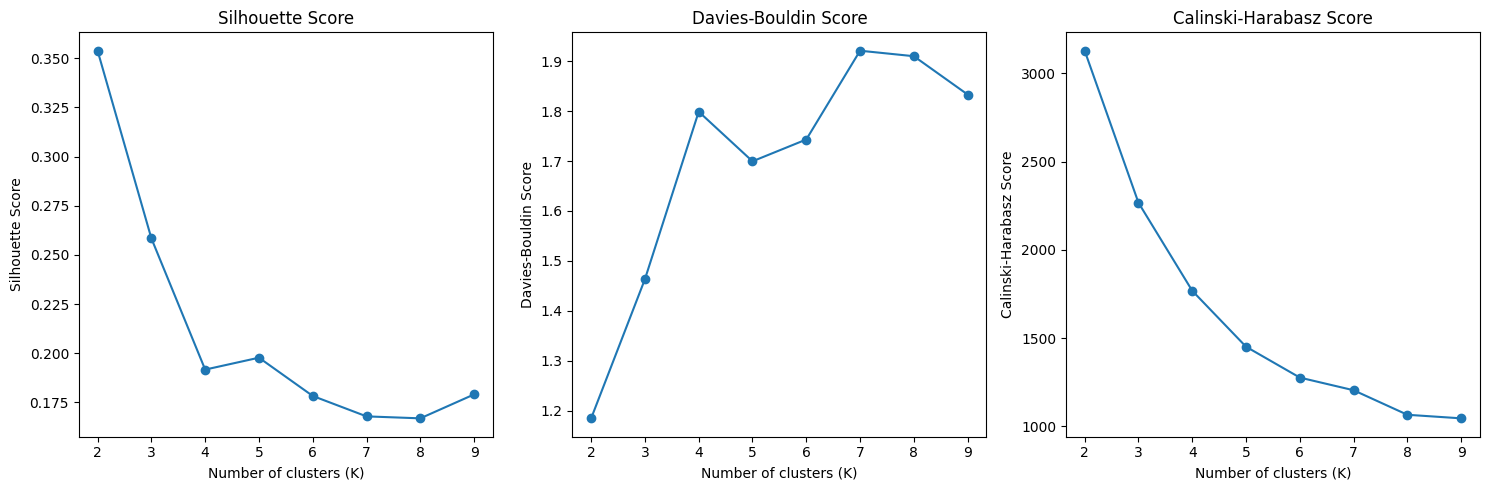

In [10]:
plot_si_da_ca(embeddings_df)

In [11]:
banking_si_da_ca = compute_si_da_ca(embeddings_df, 2)

Number of clusters: 2
Silhouette Score 0.3537579440422137
Davies-Bouldin Index 1.1845097132248443
Calinski Harabasz Score 3127.8793899586753


#### Embeddings from Text + Numerical   

In [22]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s: %s, " % (col, str(sample[col]).strip())
    return {"concat": concat}

columns = banking_df.columns.tolist()
ds = Dataset.from_pandas(banking_df)
banking_ds = ds.map(combine_data_ordered)
banking_ds = banking_ds.remove_columns(ds.column_names)
print(f'Example: {banking_ds['concat'][0]}')

Map:   0%|          | 0/4521 [00:00<?, ? examples/s]

Example: age: 30, job: unemployed, marital: married, education: primary, default: no, balance: 1787, housing: no, loan: no, contact: cellular, 


In [26]:
sentence_embedder = ParaphraseMpnetEmbeddings()
df = pd.DataFrame()
df['embeddings'] = pd.DataFrame(banking_ds)['concat'].map(sentence_embedder.get_embedding)

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [33]:
embeddings_df = pd.DataFrame(df['embeddings'].tolist())

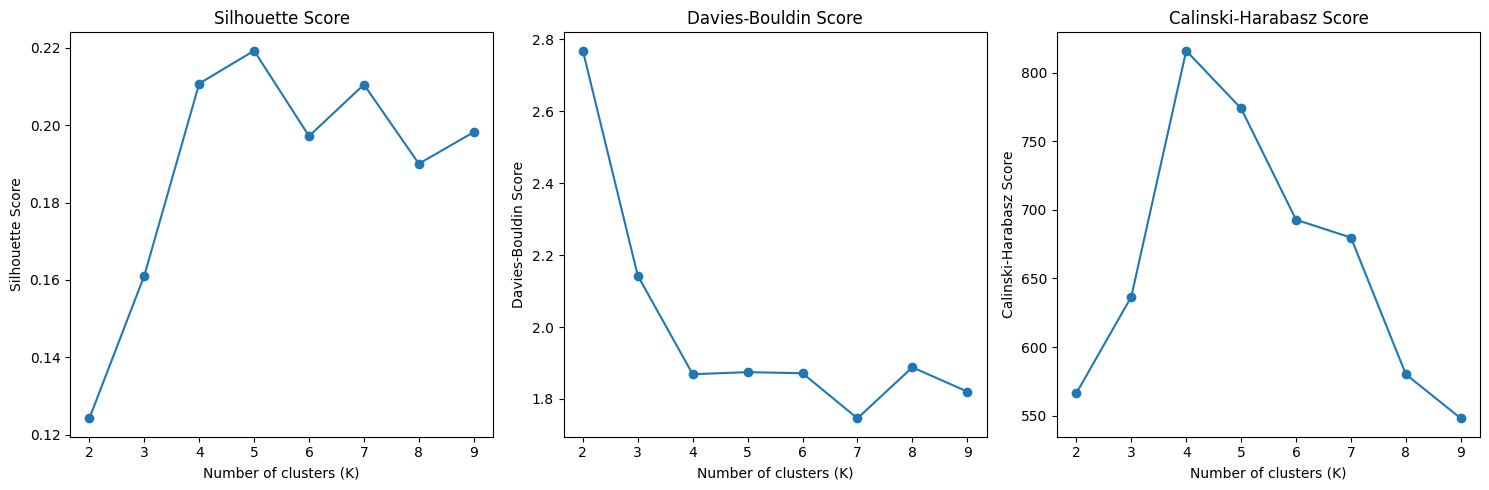

In [35]:
plot_si_da_ca(embeddings_df)

In [37]:
olist_si_da_ca = compute_si_da_ca(embeddings_df, 5)

Number of clusters: 5
Silhouette Score 0.22160057723522186
Davies-Bouldin Index 1.943708440341006
Calinski Harabasz Score 775.4327548111446


### Olist

In [12]:
olist_df =pd.read_csv('/hadatasets/fillipe.silva/LLMSegm/data/olist/test_rfm.csv')
olist_df.head()

,Recency,Frequancy,Monetary
0,149,1,314.96
1,406,1,231.27
2,512,1,99.35
3,423,2,166.28
4,99,1,40.22


In [13]:
olist_df['Recency'].describe()

count    18199.000000
mean       234.424034
std        151.976844
min         -1.000000
25%        112.000000
50%        216.000000
75%        343.000000
max        694.000000
Name: Recency, dtype: float64

In [14]:
olist_df['Frequancy'].describe()

count    18199.000000
mean         1.231826
std          0.912267
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: Frequancy, dtype: float64

In [15]:
olist_df['Monetary'].describe()

count    18199.000000
mean       203.580380
std        403.282338
min         10.070000
25%         63.270000
50%        112.300000
75%        200.330000
max      22346.600000
Name: Monetary, dtype: float64

In [16]:
sentence_embedder = ParaphraseMpnetEmbeddings()
dice_recency = DICE(d=20, min_bound=-1, max_bound=694)
dice_frequancy = DICE(d=20, min_bound=1, max_bound=38)
dice_monetary = DICE(d=20, min_bound=9.59, max_bound=109312.64)

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
df = pd.DataFrame()
df['r'] = olist_df['Recency'].apply(dice_recency.make_dice)
df['f'] = olist_df['Frequancy'].apply(dice_frequancy.make_dice)
df['m'] = olist_df['Monetary'].apply(dice_monetary.make_dice)

In [18]:
embeddings_df = pd.DataFrame(df.apply(lambda row: np.concatenate((row['r'], row['f'], row['m'])), axis=1).tolist())

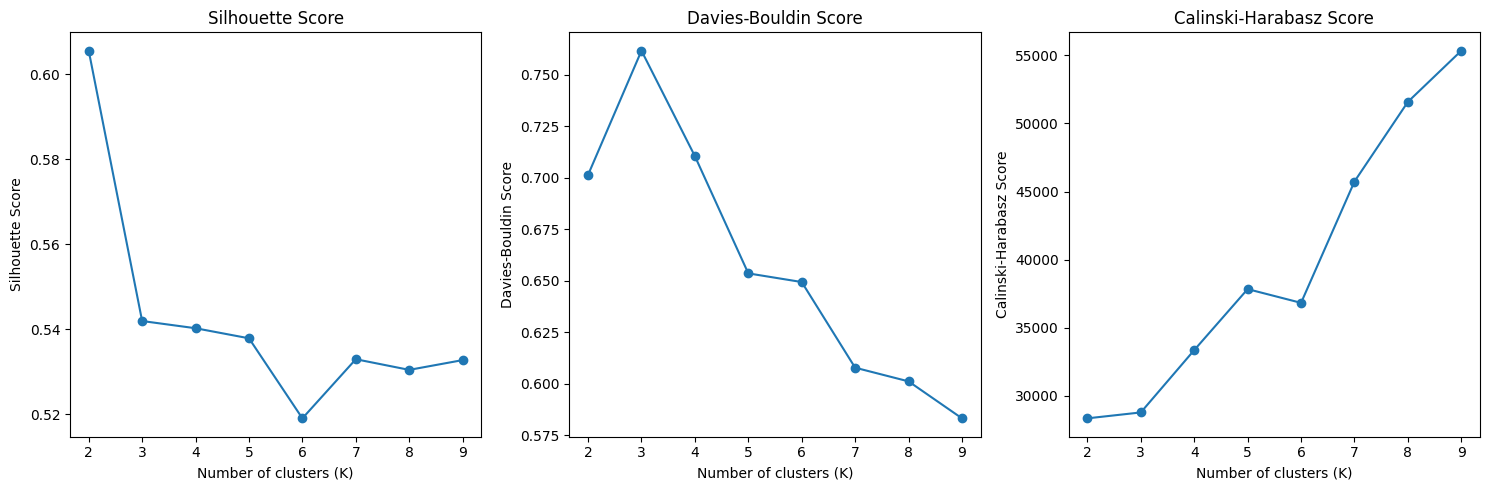

In [19]:
plot_si_da_ca(embeddings_df)

In [20]:
olist_si_da_ca = compute_si_da_ca(embeddings_df, 2)

Number of clusters: 2
Silhouette Score 0.6055637858786206
Davies-Bouldin Index 0.7013500515098317
Calinski Harabasz Score 28348.867311676742
